In [66]:
import ConnectionNetworkX as cnx
import numpy as np
import networkx as nx
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm


# Solving the Beckmann problem on a grid graph, i.e., pixel space.

Until implementation of adam solver is optimized, we use the L2 least squares approach as a proxy.

[ 3.84294392e-02  3.84294392e-02  1.92610933e-02  1.92610933e-02
  9.63054666e-03  9.63054666e-03  9.63054666e-03  9.63054666e-03
 -1.27503202e-15  3.19037647e-16]
MOST LIKELY CONSISTENT: |lambda_min| < 1e-8. 


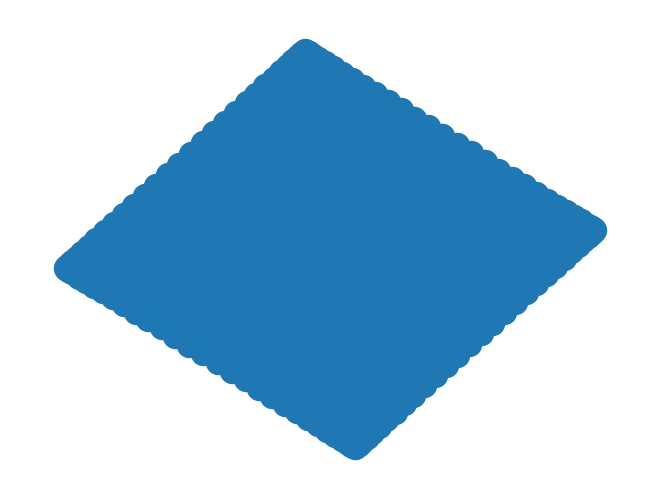

In [67]:

GRID_WIDTH = 32
GRID_HEIGHT = 32
INTRINSIC_DIM = 2

gridGraph = cnx.cnxFromPixelGrid(GRID_WIDTH, GRID_HEIGHT, INTRINSIC_DIM)

gridGraphIncidenceMatrix = gridGraph.connectionIncidenceMatrix

gridGraph.printConnectionLaplacianEigenvalues()
nx.draw_spectral(gridGraph)


In [68]:

FROM_NODE_INDEX = 0
TO_NODE_INDEX = 15

mu = np.zeros((gridGraph.nNodes * INTRINSIC_DIM, 1)).flatten()[:,None]
nu = np.zeros((gridGraph.nNodes * INTRINSIC_DIM, 1)).flatten()[:,None]

mu[ (FROM_NODE_INDEX * INTRINSIC_DIM) : ((FROM_NODE_INDEX + 1) * INTRINSIC_DIM)] = 1
nu[ (TO_NODE_INDEX * INTRINSIC_DIM) : ((TO_NODE_INDEX + 1) * INTRINSIC_DIM)] = 1

c = mu - nu
c.reshape((gridGraph.nNodes, INTRINSIC_DIM))

B = gridGraphIncidenceMatrix.toarray()

# L2 least squares
c_sol, residuals, _, _ = np.linalg.lstsq(B, c)


C:\Users\Sawyer\AppData\Local\Temp\ipykernel_13684\1607986557.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(B, c)


100%|██████████| 1024/1024 [00:01<00:00, 583.04it/s]


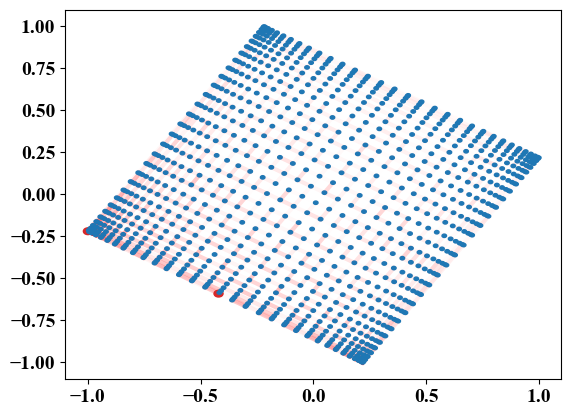

In [73]:

spectralEmbedding = nx.spectral_layout(gridGraph)

TOLERANCE = 1e-4
MAX = np.amax(abs(c_sol))

fig, ax = plt.subplots()
ax.set_xlim((-1.1, 1.1))
ax.set_ylim((-1.1, 1.1))


for node in tqdm(list(range(gridGraph.nNodes))):
    center = spectralEmbedding[node][0], spectralEmbedding[node][1]
    if node in [FROM_NODE_INDEX, TO_NODE_INDEX]:
        col="tab:red"
        zNode=4
        r=2e-2
         #ax.text(center[0], center[1], str(node+1))
    else:
        col="tab:blue"
        zNode=4
        r=1e-2
    nodeLabel = matplotlib.patches.Circle(center, radius=r, color=col, zorder=zNode)
    ax.add_patch(nodeLabel)


for edgeIndex, edge in zip(range(gridGraph.nEdges), list(gridGraph.edges())):

    if abs(c_sol[edgeIndex])[0] > TOLERANCE:
        col=(1, 0, 0, abs(c_sol[edgeIndex])[0]/MAX)
        z = 3
    else:
        #col="tab:blue"
        col=(1,1,1,0)
        z = 3

    fromNode = edge[0]
    toNode = edge[1]
    centerFromNode = spectralEmbedding[fromNode][0], spectralEmbedding[fromNode][1]
    centerToNode = spectralEmbedding[toNode][0], spectralEmbedding[toNode][1]

    ax.plot((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]), color=col, lw=3)
    # edgeLabel = Line3D((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]), (centerFromNode[2], centerToNode[2]), color=col, lw=3)
    # edgeLabel.zorder = z
    # ax.add_line(edgeLabel)

plt.show()

# xData, yData = spectralEmbedding.values


In [70]:
import torch

'''
phi,c: |V|d x 1
B: |E|d x |V|d      Connection incidence matrix
w: |E| x 1          Edge weights
c: |V|d x 1         c = alpha-beta; i.e. difference of densities
'''
def loss_fn(phi, B, w, c, alpha):
    loss0 = -torch.sum(phi*c)

    loss1 = torch.matmul(B, phi).reshape((w.shape[0],-1))
    loss1 = torch.linalg.norm(loss1, dim=1)
    loss1 = loss1 - w
    loss1 = torch.nn.ReLU()(loss1)
    loss1 = torch.sum(loss1**2)

    loss = loss0 + (0.5/alpha)*loss1
    return loss

def optimize(B, w, c, alpha, learning_rate, n_epochs, phi0 = None, print_freq=10):
    if phi0 is None:
        phi = torch.randn(B.shape[1], 1, requires_grad=True)
    else:
        phi = torch.tensor(phi0, requires_grad=True)
    optimizer = torch.optim.Adam([phi], lr=learning_rate)
    for epoch in range(n_epochs):
        # Compute loss
        loss = loss_fn(phi, B, w, c, alpha)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % print_freq == 0:
            print(f"epoch: {epoch}, loss: {loss:>7f}")
    return phi